# Часть 1: Denoising score matching


Давайте обучим модель, которая будет генерировать распределение 2D-точек на плоскости. Типа такого:

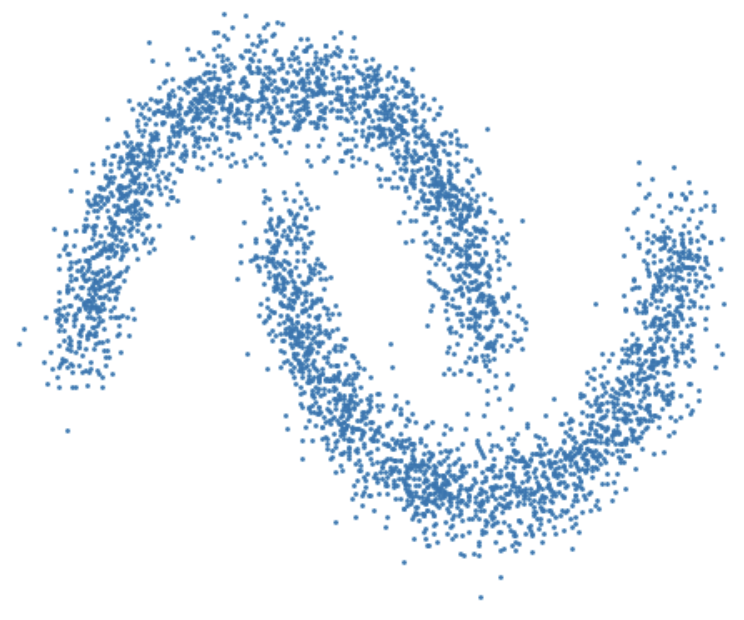


## Как запусить код?
<видео>

---

Проведем некоторую подотовительную работу:

In [1]:
# # !pip install --upgrade --no-cache-dir gdown

# # COMMIT_HASH = "2180d8447bc1c62bf662505d73f60d3e0d7ff03c"
# # !if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
# !git clone https://github.com/r-isachenko/dgm_utils.git
# %cd dgm_utils
# !git checkout {COMMIT_HASH}
# !pip install ./
# %cd ./..
# !rm -Rf dgm_utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import dgm_utils

In [4]:
from tqdm import tqdm
from typing import List, Tuple
import math
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import make_moons
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

Вот так выглядят точки, которые мы хотим сгенерировать: 

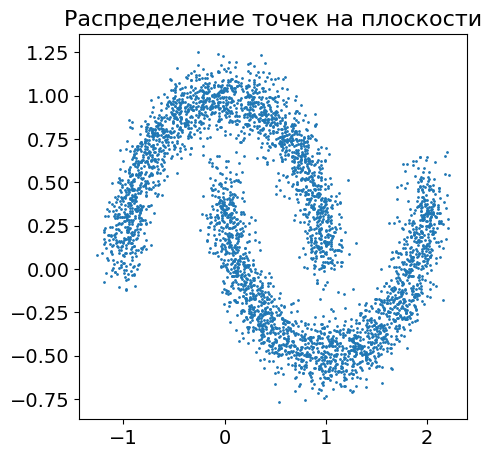

In [6]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
dgm_utils.visualize_2d_data(train_data)

**Что такое Ланжевеновская динамика?**

Это одна из первых форм диффузии и одна из самых интуитивно понятых. Она позволяет моделировать распределения, обучая тем самым генеративные модели.

Спойлер: вот так выглядит модель, обученная генерировать наши данных с помощью Лангевеновской динамики

![image](gifs/dsm2.gif)

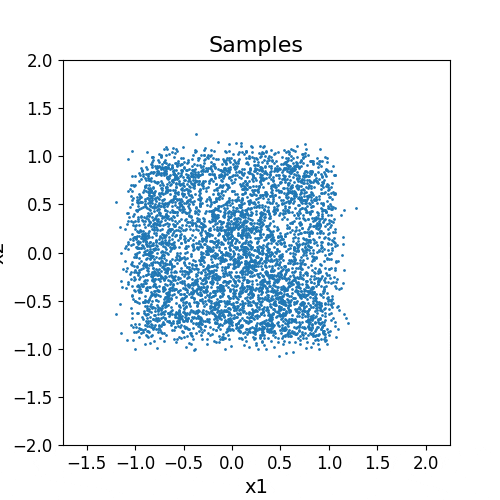

In [7]:
from IPython.display import Image
Image(open('gifs/dsm2.gif','rb').read())

Как на пальцах работает Ланжевеновская динамика?
- Есть частицы. Точки в многомерном пространстве. Можно о них думать как о лодках, плывущих по взволнованному морю
- На эти частицы действуют силы. В паруса лодок дует ветер и заставляет их двигаться в одном направлении
- Частицы начинают двигаться и выстраиваться в упорядоченную сруктуру. Лодки выстариваются в строй, образуют флотилию

#### На самом деле есть какие-то умные слова и математические формулы, объясняющие как и почему это работает, но не будем вдаваться

Для начала определяется функция оценки (score function) как:
$$
    \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) = \nabla_{\mathbf{x}}\log p(\mathbf{x}| \boldsymbol{\theta}).
$$

Затем мы минимизируем расхождение Фишера для получения функции оценки:
$$
    D_F(\pi, p) = \frac{1}{2}\mathbb{E}_{\pi}\bigl\| \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}) - \nabla_{\mathbf{x}} \log \pi(\mathbf{x}) \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}
$$.

Имея функцию оценки, мы используем Ланжевеновскую динамику для получения сэмплов из нашей модели:
$$
    \mathbf{x}_{l + 1} = \mathbf{x}_l + \frac{\eta}{2} \cdot \nabla_{\mathbf{x}_l} \log p(\mathbf{x}_l | \boldsymbol{\theta}) + \sqrt{\eta} \cdot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I}).
$$

Однако расхождение Фишера сложно вычислить, поэтому мы используем процесс добавления шума для получения зашумлённых выборок $\mathbf{x}_{\sigma} = \mathbf{x} + \sigma \cdot \boldsymbol{\epsilon}$.

Минимизация расхождения Фишера для зашумлённых сэмплов эквивалентна следующей целевой функции:
$$
    \mathbb{E}_{q(\mathbf{x}_{\sigma})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma}) \bigr\|^2_2 = \\
    = \mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) - \nabla_{\mathbf{x}_{\sigma}} \log q(\mathbf{x}_{\sigma} | \mathbf{x}) \bigr\|^2_2 + \text{const}(\boldsymbol{\theta}).
$$

Здесь
$$
    \log q(\mathbf{x}_{\sigma} | \mathbf{x}) = - \frac{\mathbf{x}_{\sigma} - \mathbf{x}}{\sigma^2} = - \frac{\boldsymbol{\epsilon}}{\sigma}.
$$

Таким образом, цель выравнивания оценок с подавлением шума заключается в следующем:

$$
\mathbb{E}_{\pi(\mathbf{x})} \mathbb{E}_{q(\mathbf{x}_{\sigma} | \mathbf{x})}\bigl\| \mathbf{s}_{\boldsymbol{\theta}, \sigma}(\mathbf{x}_{\sigma}) + \frac{\boldsymbol{\epsilon}}{\sigma} \bigr\|^2_2 \rightarrow \min_{\boldsymbol{\theta}}.
$$


In [8]:
class DenoisingScoreMatcher(nn.Module):
    def __init__(
            self,
            score_model: nn.Module,
            input_shape: Tuple[int],
            sigma: float
        ):
        super().__init__()

        self.score_model = score_model
        self.input_shape = input_shape
        self.sigma = sigma

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x: torch.Tensor):
        # образец гауссового шума
        # возмущение сэмпдлв с использованием шума и сигмы
        noise = torch.randn(size=(x.size(0), *self.input_shape)).to(x)
        noisy_x = x + noise * self.sigma

        # calculate the score model
        s = self.score_model(noisy_x)


        # вычисление лосса
        # это среднеквадратичная ошибка между функцией оценки и градиентом нормального распределения
        loss = (s + noise / self.sigma).pow(2)
        return loss

    def loss(self, x: torch.Tensor):
        return {"total_loss": self(x).mean(dim=0).sum()}

    def langevin_dynamics(self, x: torch.Tensor, num_steps: int, eta: float):
        # применим динамику Ланжевена в цикле for к начальной точке x
        eta = torch.tensor(eta)
        eta_sqrt = torch.sqrt(eta)
        
        for _ in range(num_steps):
            x = x + eta / 2 * self.score_model(x) + eta_sqrt * torch.randn(size=(x.size(0), *self.input_shape)).to(x)
        # =====
        return x

    def sample(self, num_samples: int = 64, num_steps: int=100, eta: float = 0.01):
        with torch.no_grad():
            # будем сэмплировать x_0 из U[-1, 1]
            x0 = 2. * torch.rand_like(torch.empty(num_samples, *self.input_shape)) - 1.
            x0 = x0.to(self.device)

            # применим Ланжевеновскую динамику
            x = self.langevin_dynamics(x0, num_steps=num_steps, eta=eta)
        return x


def test_denoiser_score_matcher():
    matcher = DenoisingScoreMatcher(
        score_model=nn.Linear(2, 2),
        input_shape=(2,),
        sigma=0.1
    )
    x = torch.rand(16, 2)
    assert x.size() == matcher(x).size(), matcher(x).size()
    loss = matcher.loss(x)["total_loss"]
    assert len(loss.size()) == 0
    assert list(matcher.sample(4).size()) == [4, 2]


test_denoiser_score_matcher()

Это все!

А теперь мы готовы обучать нашу модель.

In [9]:
BATCH_SIZE = 128  # any adequate value
EPOCHS = 30  # > 50
LR = 1e-2  # > 1e-3
HIDDEN_SIZE = 64  # > 32
SIGMA = 0.1  # 0.01 < x < 1.0

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


score_model = nn.Sequential(
    nn.Linear(2, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.SiLU(),
    nn.Linear(HIDDEN_SIZE, 2)
)


matcher = DenoisingScoreMatcher(
    score_model=score_model, input_shape=(2,), sigma=SIGMA
)


Давайте посмотрим как выглядит граф вычислений нашей модели. Это штука, которая описывает порядок математических операций внутри нейросети. Обычно, она изображается как дерево

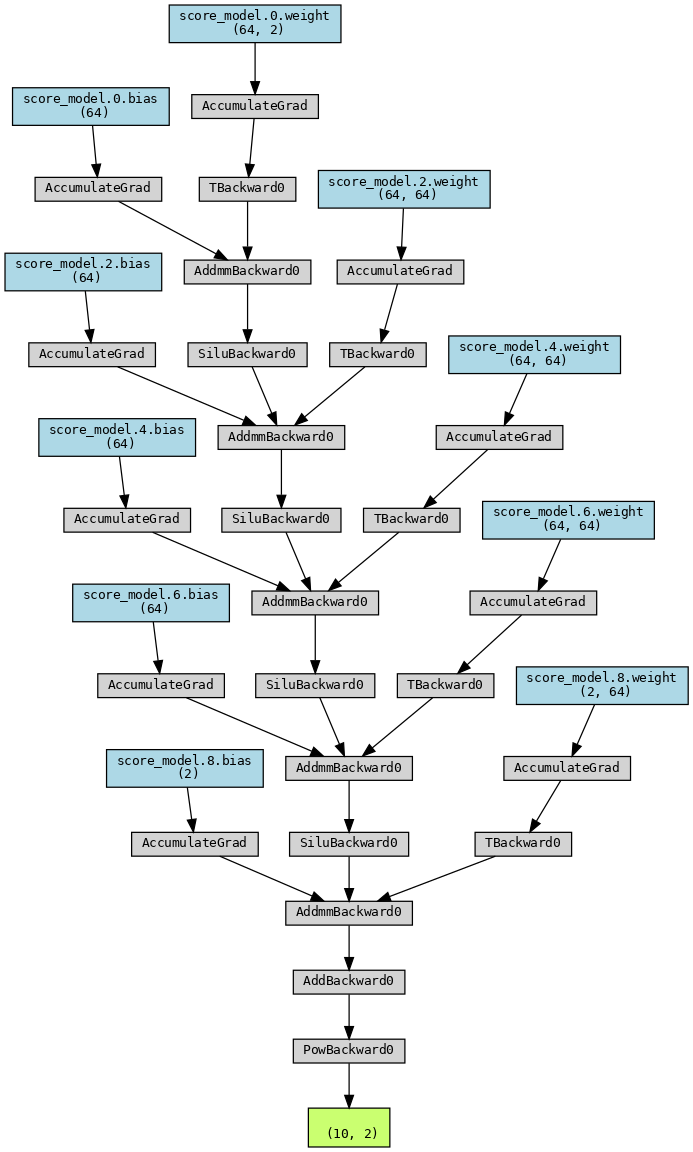

In [10]:
from torchviz import make_dot

output = matcher(torch.randn(10, 2))
dot = make_dot(output, params=dict(matcher.named_parameters()))

# Сохраним граф вычислений
dot.format = 'png'
dot.render('matcher')
Image('matcher.png')

Видим, что граф достаточно большой, но помещяется на экран. Мы взяли совсем крошечную модель. Для модели YandexART аналогичный граф занял бы целую книгу.

Теперь обучим модель. Заставим ее моделировать движение точек, предсказывая направление ветра.

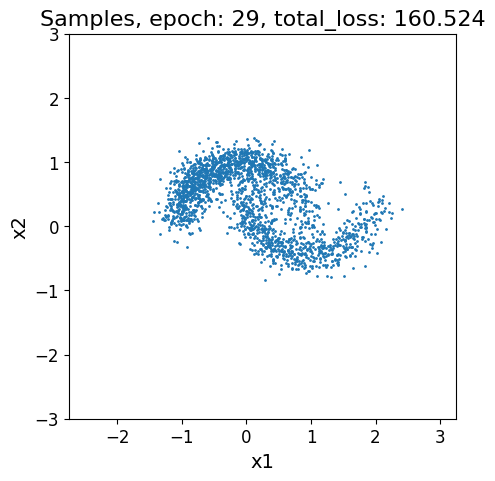

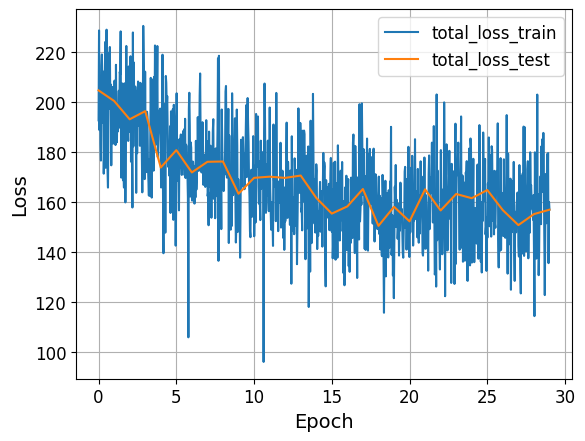

End of the training



In [11]:
matcher = DenoisingScoreMatcher(
    score_model=score_model, input_shape=(2,), sigma=SIGMA
)

optimizer = torch.optim.Adam(matcher.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

dgm_utils.train_model(
    matcher,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    n_samples=2000,
)
print()

График обучения идет вниз и останавливается на примерно стабильном значении. Это сигнализирует, что модель справилась с задачей. Также промежуточные генерации получились вполне приличными.

Наша модель обучалась примерно 30 секунд. За это время она прошла путь с полного нуля до вполне зрелого состояния. Посмотрим как выглядел этот путь:

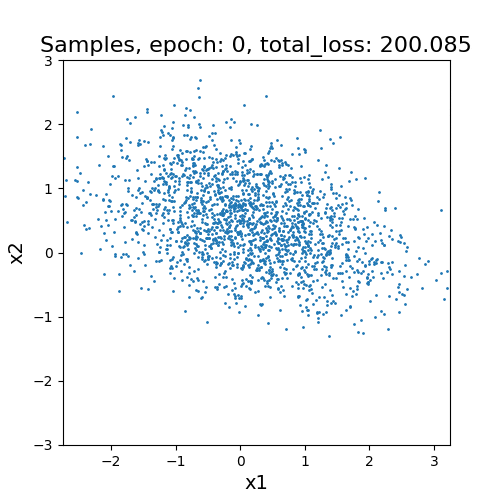

In [12]:
from IPython.display import Image
Image('gifs/train.gif')

Посмотрим, научились ли наша модель генеривать желаемое распределение точек:

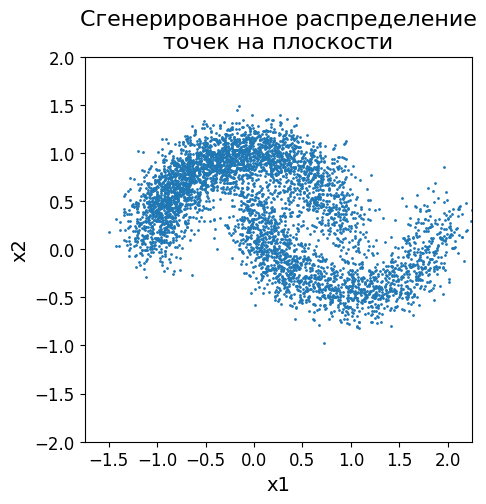

In [13]:
NUM_STEPS = 100
ETA = 0.01
 
torch.random.manual_seed(0)
samples = matcher.sample(num_samples=5000, num_steps=NUM_STEPS, eta=ETA).cpu()

dgm_utils.visualize_2d_samples(samples, title="Сгенерированное распределение\nточек на плоскости", show=False)
plt.xlim(-1.75, 2.25)
plt.ylim(-2, 2)
plt.show()

Похоже на то, что мы хотели! Давайте сравним это с тем, что мы стремились получить:

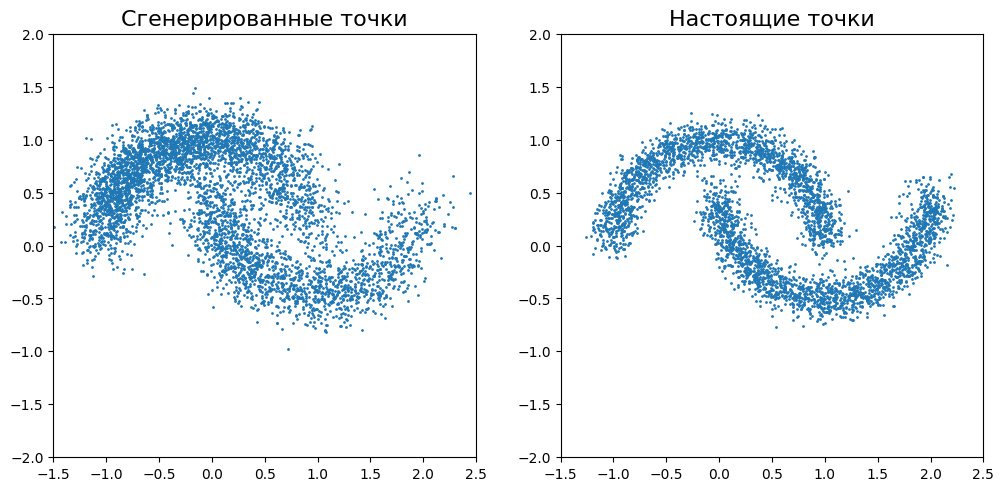

In [14]:
COUNT = 5000

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5))

ax1.scatter(samples[:, 0], samples[:, 1], s=1)
ax1.set_xlim(-1.5, 2.5)
ax1.set_ylim(-2, 2)
ax1.set_title('Сгенерированные точки', fontsize=16)

ax2.scatter(train_data[:, 0], train_data[:, 1], s=1)
ax2.set_xlim(-1.5, 2.5)
ax2.set_ylim(-2, 2)
ax2.set_title('Настоящие точки', fontsize=16)
plt.show()

Видим, что хотя распределения и похожие, они не идеально совпадают: 
1. Наша модель рисует более жирные полумесяцы (есть лишние точки). Так появляются **артефакты**
2. В некоторых местах точек наоборот не хватает (например, справа). А некоторые наоборот, слишком хорошо представлены. Так появляются **баесы**

Аналогичная проблема происходит, когда мы переходим от двумерных точек к картинкам:
1. Если нарисовался человек с 6-ю пальцами на руке это означает, что точка близка к нашему полумесяцу, но все таки немного криво расположена: это почти хорошая картинка, но не совсем
2. А если наша модель рисует только белокожых (или только чернокожых), то значит она неравномерно раскидала точки по распределению